In [25]:
import pandas as pd, numpy as np, requests, json, io, yaml, plotnine, seaborn as sns, re
from plotnine import *

The bearer token is provided for the Remote Management System to access router information via the API
https://developers.rms.teltonika-networks.com/

The PAT for teltonika is stored in a config.yml file for security

In [2]:
with open('../config.yml', 'r') as file:
    cfg = yaml.safe_load(file)

In [3]:
pat = cfg['teltonika']['pat']
bearer = f'Bearer {pat}'

The performance metrics are queried for each month - as defined by start and end dates supplied as variables in the cell below. In addition we define fields for data collected by the routers which may indicate performance in various ways. Of key interest is data usage (collected via a separate end point later).

In [4]:
start_date = "2022-09-01"
end_date = "2022-10-01"
 
fields = """id,model,name,serial,mac,wlan_mac,mqtt,
last_connection_at,updated_at,status,temperature,
signal,cell_id,connection_uptime,iccid,operator,router_uptime,wan_ip"""

API URLs

In [5]:
url950 = "https://rms.teltonika-networks.com/api/devices?limit=10&status=online&model=RUT950"
urlall = "https://rms.teltonika-networks.com/api/devices?limit=10"
shorturl = "https://rms.teltonika-networks.com/api/devices/"
csv_url = "https://rms.teltonika-networks.com/api/devices/export/csv"

Basic information about the devices, the response is in JSON. This endpoint is needed because the router id's are not returned in the csv version.

In [6]:
response_devices = requests.get(urlall, \
                                headers = {"Authorization": bearer, "Accept":"application/json"})

The API call below brings in a range of metrics defined in the field parameter. CSV endpoint used for larger datasets.


In [7]:
response_devices_csv = requests.get(csv_url, \
                                   headers = {"Authorization": bearer, "Accept":"text/csv"}, \
                                   params = {"fields":fields})

We convert to a DataFrame here for use in further analysis.

In [8]:
responses_df = pd.read_csv(io.StringIO(response_devices_csv.text))

Use the json response to get id's, then the `data-usage` endpoint to get daily usage stats from each device. Create a dataframe to hold the data usage data for each device to enable plotting to review any spikes in use - could indicate compromised security or unexpected updates.

In [9]:
devices = response_devices.json()

In [10]:
d_data = devices['data']

In [11]:
ids_sno = [(device['id'], device['serial'], device['name']) for device in d_data]

In [12]:

serials_df = pd.DataFrame(ids_sno, columns=['id', 'serial_no', 'name'])

In [13]:
site_routers_df = serials_df.copy()

In [14]:
site_routers_df['name'].astype("string")

0               RUT955_BTW_500
1           RUT955_Airport_573
2             RUT950_Spare_000
3    RUT950_Marlborough_St_672
4         RUT950_Parson_St_215
5    RUT950_Colston_Avenue_501
6         RUT950_Fishponds_463
7        RUT950_Wells_Road_270
8       RUT950_Brislington_203
Name: name, dtype: string

In [15]:
def mk_name(t_string):
    '''Strips out the start and end portions of the name string'''
    nicename = re.sub(pattern = "_", repl = " ", string = t_string[7:-4]).strip()
    return nicename    


In [16]:
site_routers_df['Site'] = site_routers_df.name.apply(mk_name)

In [17]:
site_routers_df

,id,serial_no,name,Site
0,413202,1104590839,RUT955_BTW_500,BTW
1,413145,1104560850,RUT955_Airport_573,Airport
2,406262,1114535631,RUT950_Spare_000,Spare
3,404606,1114535283,RUT950_Marlborough_St_672,Marlborough St
4,404003,1114541531,RUT950_Parson_St_215,Parson St
5,403462,1114548739,RUT950_Colston_Avenue_501,Colston Avenue
6,401873,1114530778,RUT950_Fishponds_463,Fishponds
7,401760,1114535282,RUT950_Wells_Road_270,Wells Road
8,400809,1114535706,RUT950_Brislington_203,Brislington


In [19]:
# loop over the list of tuples extracting the first item in each tuple
ids = [ID for ID, serial, name in ids_sno]


In [20]:
def datause(i_d, start_date, end_date, bearer):
    ''' function to fetch the daily data use for a router and return a dataframe'''
    time_bit = " 00:00:00"
    sd = f'{start_date}{time_bit}'
    ed = f'{end_date}{time_bit}'
    params = {"start_date":sd, "end_date":ed}
    du_url = f"https://rms.teltonika-networks.com/api/devices/{i_d}/data-usage"
    device_datause = requests.get(du_url, \
                headers = {"Authorization": bearer, "Accept":"application/json"}, \
                params = params)
    du = pd.DataFrame(device_datause.json()['data'])
    du['i_d'] = i_d
    return du
    

In [35]:
# check function operation
# du = datause(i_d = '413202', start_date = start_date, end_date = end_date, bearer = bearer)

This code loops over each router id in the list and runs the function above to get a dataframe of data use, concatenating it into one combined df.

In [21]:
bigdf=pd.DataFrame()
for i_d in ids: # for each id in the list
    du = datause(i_d = i_d, start_date = start_date, end_date = end_date, bearer = bearer) #call the function to get a df of datause
    bigdf=pd.concat([bigdf, du], ignore_index=True) # concatenate (bind_rows)
    
bigdf

,date,sim1_rx,sim2_rx,sim1_tx,sim2_tx,i_d
0,2022-09-01,2131079,0,2713677,0,413202
1,2022-09-02,2423346,0,3018082,0,413202
2,2022-09-03,2207295,0,2885533,0,413202
3,2022-09-04,2113078,0,2903646,0,413202
4,2022-09-05,2255319,0,2970863,0,413202
...,...,...,...,...,...,...
274,2022-09-27,10218684,0,4983775,0,400809
275,2022-09-28,250907034,0,10109730,0,400809
276,2022-09-29,9849940,0,4325711,0,400809
277,2022-09-30,168847250,0,10008433,0,400809


The consolidated DataFrame for all routers shows the receive (rx) and transmit (tx) data use for each SIM card in the router. In our routers, only one SIM is used (sim1), so the sim2 columns can be dropped. In addition, the data is shown in bytes. A simple operation converts into MB for optimal display after adding the rx and tx components together.

Further, it is useful to see the cumulative data use for each month as exceededing data allowances ('overage') incurs a cost. The data allowances are spread over the whole fleet of routers and are equivalent to 3GB per router per month. The allowances roll over on the 1st of the month.

In [22]:
bigdf['total_data'] = (bigdf['sim1_rx'] + bigdf['sim1_tx']) / (1024 * 1024)
bigdf.drop(columns = ['sim1_rx', 'sim2_rx', 'sim2_tx', 'sim1_tx'], inplace = True)

# df['cumsum'] = df.groupby('id')['val'].transform(pd.Series.cumsum)

bigdf['cum_data'] = bigdf.groupby('i_d')['total_data'].transform(pd.Series.cumsum)


A `plot_data` Data Frame is constructed by joining the router meta data to the main dataset to enable meaningful display of the chart to be plotted later.

In [23]:
plot_data = pd.merge(left = bigdf, right = site_routers_df, left_on = 'i_d', right_on = 'id', how = 'inner')

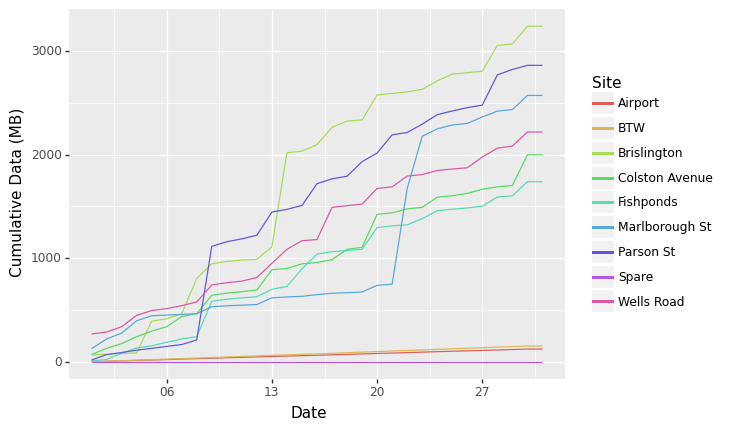

<ggplot: (8734762564813)>

In [29]:

(plotnine.ggplot(plot_data, aes('date', 'cum_data', group = 'factor(Site)', color = 'factor(Site)')) +
geom_line() +
scale_x_date(breaks = "1 week", date_labels = "%d") +
labs(x = "Date", colour = "Site", y = "Cumulative Data (MB)")) 


NameError: name 'ax' is not defined

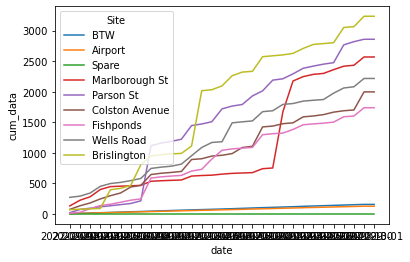

In [33]:
# sns.lineplot(data=flights, x="year", y="passengers", hue="month")

sns.lineplot(data = plot_data, x = 'date', y = 'cum_data', hue = 'Site' )
ax.xaxis.set_major_formatter(DateFormatter('%d'))